In [6]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
from IPython.display import Audio

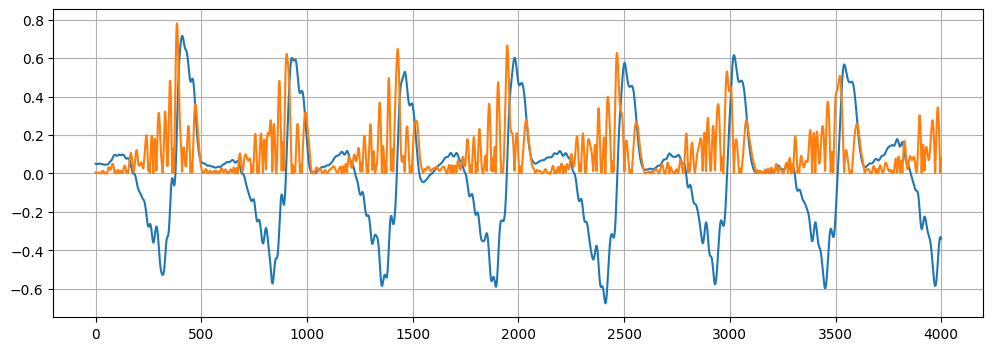

In [7]:
step = 50000
plt.figure(figsize=(12, 4))
spf = wave.open("16bit/Dee light.wav", "rb")
signal = spf.readframes(spf.getnframes())
osc_bytes = signal[step:step+8000]
osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)
plt.plot(osc_np_norm)
plt.plot(abs(np.diff(osc_np_norm,n=1)*20))
plt.grid()
plt.show()

In [8]:
# Slew is a function that simulates the envelope of a signal
def slew(envelope, slope, attack_coeff=0.9, release_coeff=0.9):
    if abs(slope) > envelope:
        envelope = attack_coeff * (envelope - abs(slope)) + abs(slope)
    else:
        envelope = release_coeff * (envelope - abs(slope)) + abs(slope)
    return envelope

# Non-linear transformation function forces signal to be higer if its above a threshold and lower if its below
# A bit like a sigmoid function

def non_linear_transform(x,threshold=0.5):
    if x > threshold:
        return 1 - (x - threshold) ** 1.5
    elif x < threshold:
        return x ** 1.5
    else:
        return x

In [380]:
attack_coeff=0.93
release_coeff=0.98
#End values
#start_point = 1040000
#end_point = 5500

#Start values
start_point =116000
end_point = 10000

# These are needed to calculate the minimum number of steps to wait before the next peak
sample_rate = spf.getframerate()
max_freq = 200
min_freq = 40

min_peak_count = sample_rate / max_freq

Number of frames: 1264248


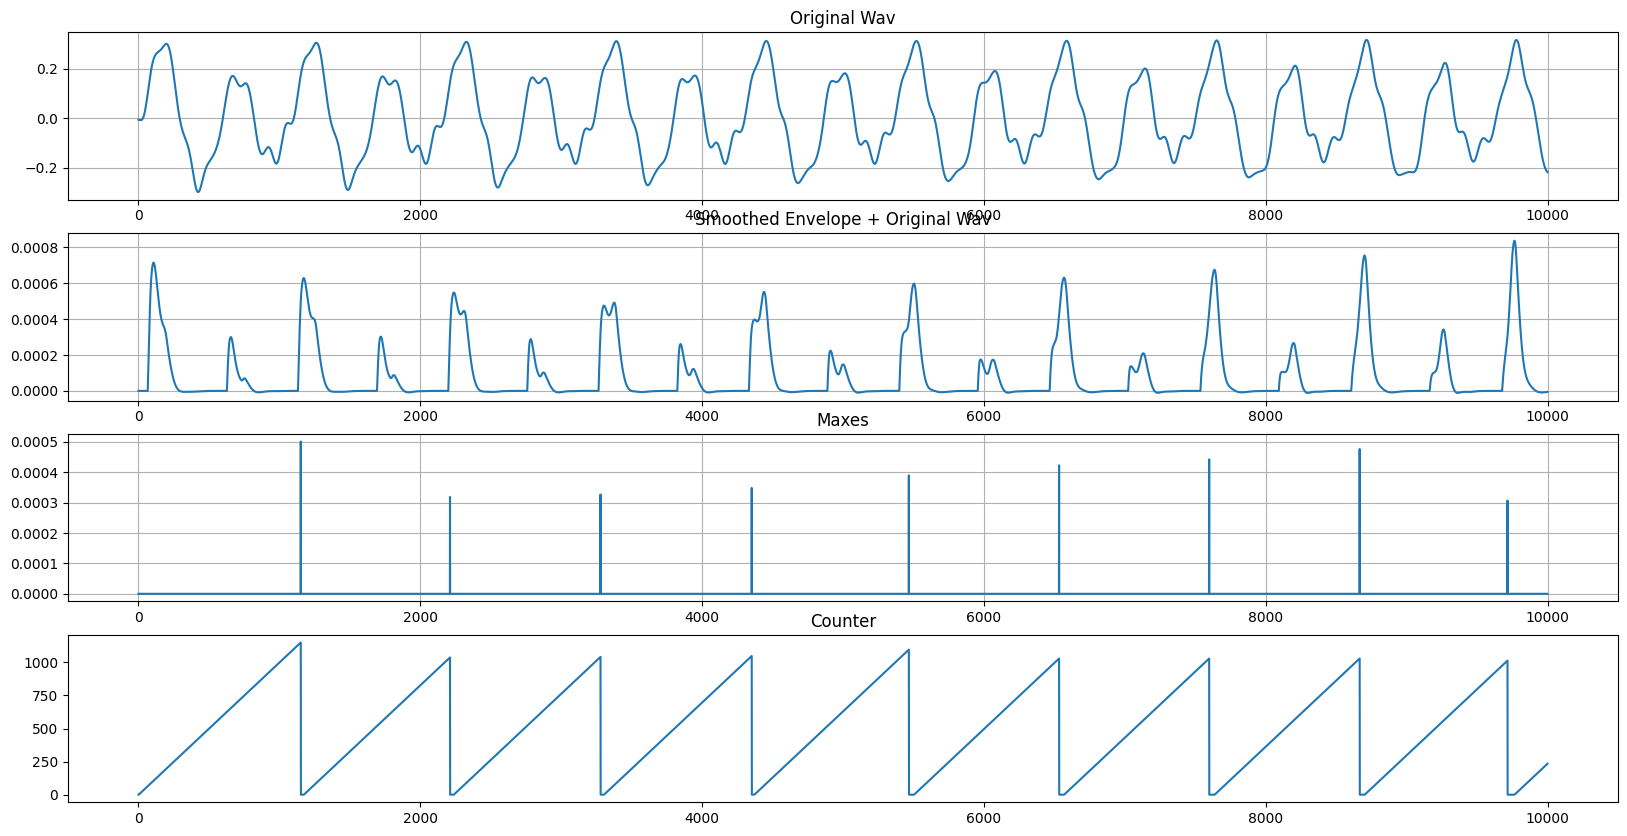

In [399]:
# End values
wav_values = []
wav_slope = []
wav_envelope = []
envelope_slope = []
smoothed_slope_plus_original = []
maxes = []
counter_array = []
start_phasor = True
wav_start = 0
wav_len = 160000

slope_padding = 30
threshold=0.010
count_state = False

last_max = 0
current_max = 0


# Loads the wavefile into the frames `spf`
#spf = wave.open("16bit/Dee light.wav", "rb")
spf = wave.open("16bit/Recording.wav", "rb")

# Converts the frames into a byte array then into a numpy array and normalizes it
no_of_frames = spf.getnframes()
print(f"Number of frames: {no_of_frames}")
signal = spf.readframes(no_of_frames)
osc_bytes = signal #[wav_start:wav_start+wav_len*2]
#osc_bytes = signal[0:no_of_frames*2]

osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)

envelope = 0
current_envelope_slope = 0
counter = 0

ranger = no_of_frames #10000000# len(osc_np_norm)
for i in range(0, end_point):
    counter_array.append(counter)

    # Append the current value of the signal to the wav_values array
    current_actual_value = osc_np_norm[i+start_point]
    wav_values.append(current_actual_value)

    # Append the current value of the signal multiplied by the envelope to the smoothed_slope_plus_original array
    smoothed_slope_plus_original.append(current_actual_value * envelope)

    # This first if statement is to avoid the first value of the slope not being available
    if i > 1:
        
        #The current_slope is the difference between the current value and the previous value
        current_slope = osc_np_norm[i+start_point] - osc_np_norm[i+start_point-1]

        #Only add to the wav_slope array if the current value is above 0.1 and has a positive slope
        if (osc_np_norm[i+start_point] > 0.1) and (current_slope > 0):
            wav_slope.append(current_slope)        
        else:
            wav_slope.append(0)

        # check if smoothed_slope_plus_original is going up or down
        #if (counter > 10):
        #if (counter > min_peak_count):
        if (smoothed_slope_plus_original[i-1] < smoothed_slope_plus_original[i]) and (smoothed_slope_plus_original[i] > 0.0003):
            current_max = smoothed_slope_plus_original[i]
            if (current_max > last_max*0.7) and (counter > min_peak_count):
                count_state = False
                counter = 0
                maxes.append(current_max)
                #counter += 10
                # if (counter > min_peak_count):
                #     maxes.append(current_max)
                #     counter = 0
            else:
                maxes.append(0)
        #else:
        #    maxes.append(0)
        #    last_max = current_max
        #    counter = 0
        else: 
            maxes.append(0)
            last_max = current_max
            count_state = True
        # else:
        #     maxes.append(0)
        #     if (counter > min_peak_count):# and (current_max > last_max*0.85):
        #         current_max = smoothed_slope_plus_original[i]
        #         if (smoothed_slope_plus_original[i-1] > smoothed_slope_plus_original[i]):
        #             maxes.append(current_max)
        #             counter = 0
        #             last_max = current_max
        #     else:
        #         maxes.append(0)
        # else:
        #     maxes.append(0)


        
    else:
        wav_slope.append(0)
        maxes.append(0)

    # Create a bigger gap between peaks multiplying the current value by the envelope
    

    # Add the envelope value calculated in the last loop to the wav_envelope array     
    # wav_envelope.append(envelope)
    # Smooth the envelope by using the `slew` function
    envelope = slew(envelope, wav_slope[i],attack_coeff=attack_coeff, release_coeff=release_coeff)
    if (count_state):
        counter += 1

    
    #Transform the envelope using the `non_linear_transform` function to try exagerate the peaks
    #wav_envelope_non_linear.append(non_linear_transform(envelope,threshold=threshold))
    #print(f"{i}: {wav_values[i]} - {wav_slope[i]} - {wav_envelope[i]} - {maxes[i]}")# - {wav_envelope_non_linear[i]}")

fig, axs = plt.subplots(4,1,figsize=(20,10))
axs[0].plot(wav_values)
axs[0].title.set_text("Original Wav")
# axs[1].plot(wav_envelope)
# axs[1].title.set_text("Smoothed Envelope")
axs[1].plot(smoothed_slope_plus_original)
axs[1].title.set_text("Smoothed Envelope + Original Wav")
axs[2].plot(maxes)
axs[2].title.set_text("Maxes")
axs[3].plot(counter_array)
axs[3].title.set_text("Counter")
axs[0].grid()
axs[1].grid()
axs[2].grid()
# axs[3].grid()
#axs[3].plot(wav_envelope_non_linear)    

In [298]:
smoothed_slope_plus_original[1]

-0.0

Number of frames: 1264248


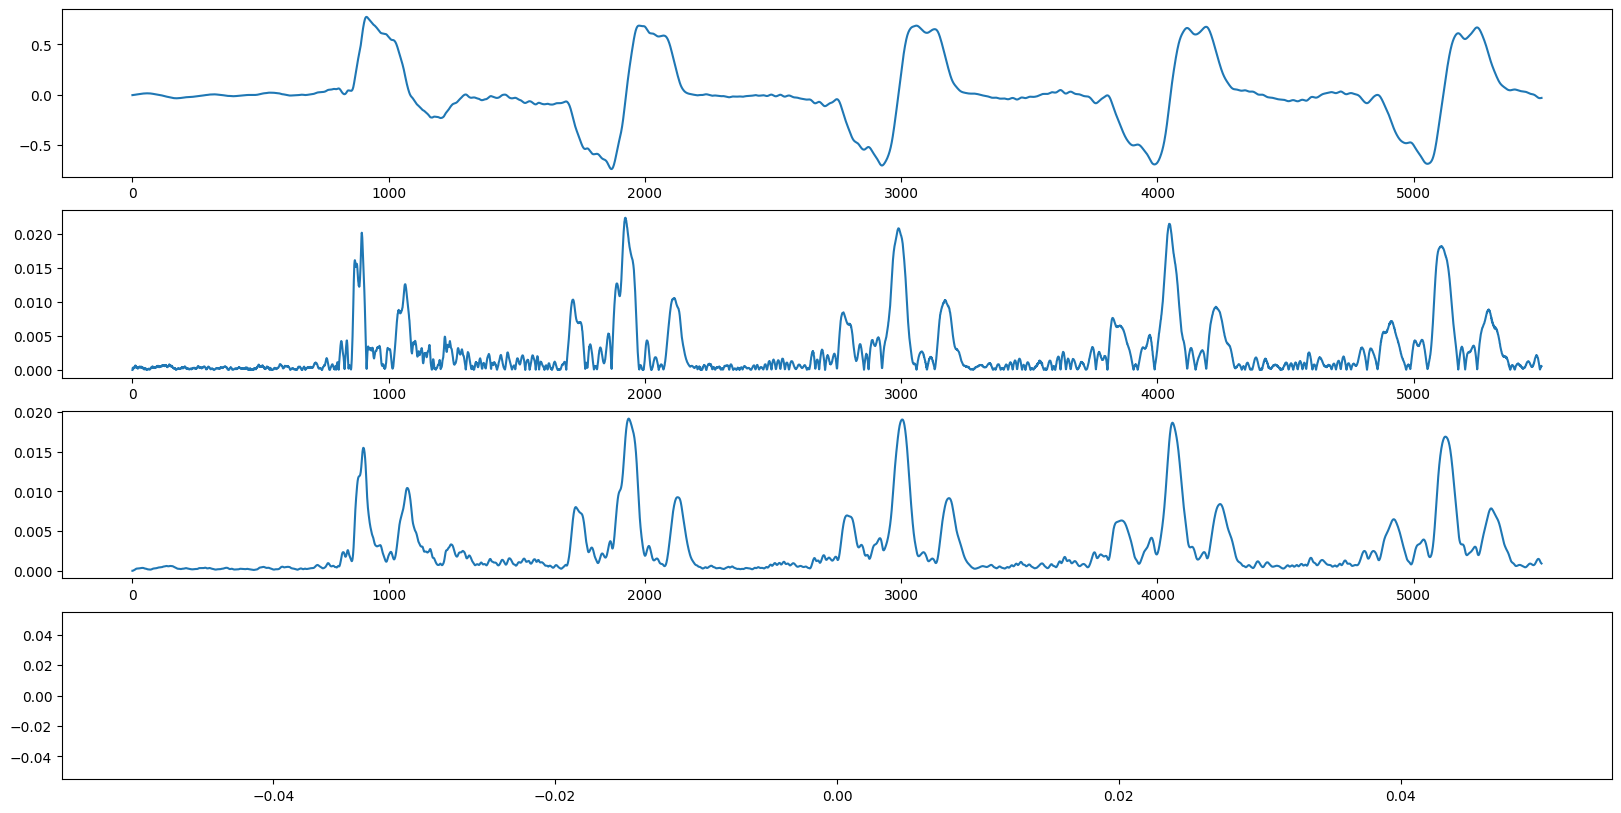

In [174]:
## Start values
wav_values = []
wav_slope = []
wav_envelope = []
wav_envelope_non_linear = []
maxes = []

wav_start = 0
wav_len = 160000

slope_padding = 30
threshold=0.010

last_max = 0
current_max = 0


# Loads the wavefile into the frames `spf`
#spf = wave.open("16bit/Dee light.wav", "rb")
spf = wave.open("16bit/Recording.wav", "rb")

# Converts the frames into a byte array then into a numpy array and normalizes it
no_of_frames = spf.getnframes()
print(f"Number of frames: {no_of_frames}")
signal = spf.readframes(no_of_frames)
osc_bytes = signal #[wav_start:wav_start+wav_len*2]
#osc_bytes = signal[0:no_of_frames*2]

osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)

# There are needed to calculate the minimum number of steps to wait before the next peak
sample_rate = spf.getframerate()
max_freq = 200
min_freq = 40

min_peak_count = sample_rate / max_freq


envelope = 0
counter = 0
start_point =49000
end_point = 5500
ranger = no_of_frames #10000000# len(osc_np_norm)
for i in range(0, end_point):

    # Append the current value of the signal to the wav_values array
    wav_values.append(osc_np_norm[i+start_point])

    # Calculate the slope of the signal from the difference between the current value to the previous value
    if i > 0:
        wav_slope.append(abs(osc_np_norm[i+start_point] - osc_np_norm[i+start_point-1]))
        # if counter > min_peak_count:
        #     if (wav_slope[i] > current_max) and (wav_slope[i] > 0.01):
        #         current_max = wav_slope[i]
        #         maxes.append(current_max)
        #         counter = 0
        #     else:
        #         maxes.append(0)
        # counter += 1
    else:
        wav_slope.append(0)

    # Add the envelope value calculated in the last loop to the wav_envelope array     
    wav_envelope.append(envelope)

    # Smooth the envelope by using the `slew` function
    envelope = slew(envelope, wav_slope[i],attack_coeff=attack_coeff, release_coeff=release_coeff)
    
    #Transform the envelope using the `non_linear_transform` function to try exagerate the peaks
    wav_envelope_non_linear.append(non_linear_transform(envelope,threshold=threshold))
    #print(f"{i}: {wav_values[i]} - {wav_slope[i]} - {wav_envelope[i]} - {wav_envelope_non_linear[i]}")

fig, axs = plt.subplots(4,1,figsize=(20,10))
axs[0].plot(wav_values)
axs[1].plot(wav_slope)
axs[2].plot(wav_envelope)
axs[3].plot(maxes)   
#axs[3].plot(wav_envelope_non_linear)    

Number of frames: 1264248


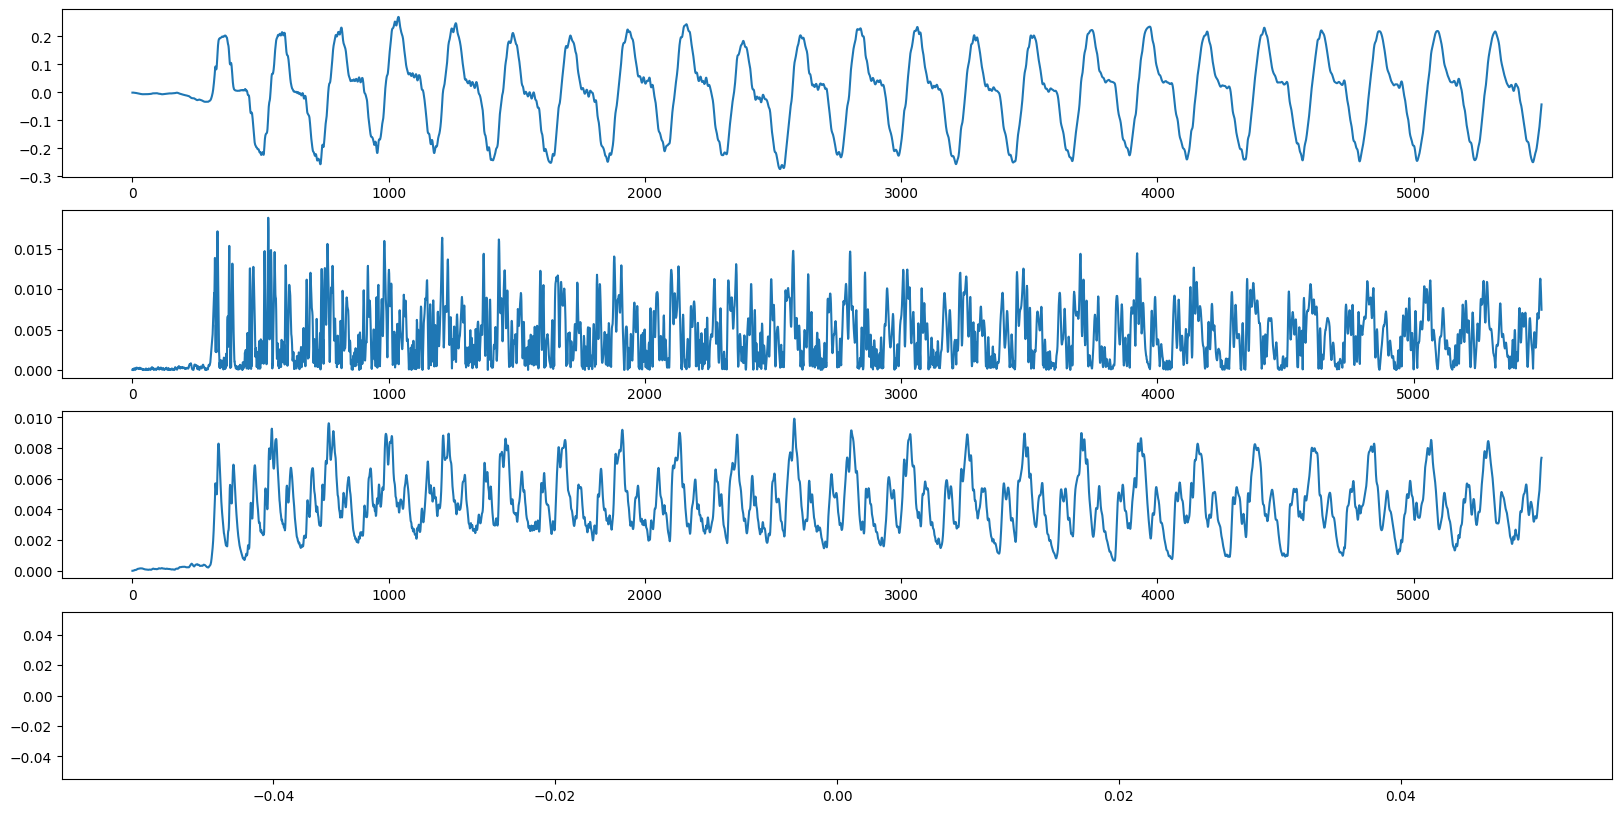

In [ ]:
## Making a copy of this cell because it works!


wav_values = []
wav_slope = []
wav_envelope = []
wav_envelope_non_linear = []
maxes = []

wav_start = 0
wav_len = 160000

slope_padding = 30
threshold=0.010

last_max = 0
current_max = 0


# Loads the wavefile into the frames `spf`
#spf = wave.open("16bit/Dee light.wav", "rb")
spf = wave.open("16bit/Recording.wav", "rb")

# Converts the frames into a byte array then into a numpy array and normalizes it
no_of_frames = spf.getnframes()
print(f"Number of frames: {no_of_frames}")
signal = spf.readframes(no_of_frames)
osc_bytes = signal #[wav_start:wav_start+wav_len*2]
#osc_bytes = signal[0:no_of_frames*2]

osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)

# There are needed to calculate the minimum number of steps to wait before the next peak
sample_rate = spf.getframerate()
max_freq = 200
min_freq = 40

min_peak_count = sample_rate / max_freq


envelope = 0
counter = 0
start_point = 1048500
end_point = 5500
ranger = no_of_frames #10000000# len(osc_np_norm)
for i in range(0, end_point):

    # Append the current value of the signal to the wav_values array
    wav_values.append(osc_np_norm[i+start_point])

    # Calculate the slope of the signal from the difference between the current value to the previous value
    if i > 0:
        wav_slope.append(abs(osc_np_norm[i+start_point] - osc_np_norm[i+start_point-1]))
        # if counter > min_peak_count:
        #     if (wav_slope[i] > current_max) and (wav_slope[i] > 0.01):
        #         current_max = wav_slope[i]
        #         maxes.append(current_max)
        #         counter = 0
        #     else:
        #         maxes.append(0)
        # counter += 1
    else:
        wav_slope.append(0)

    # Add the envelope value calculated in the last loop to the wav_envelope array     
    wav_envelope.append(envelope)

    # Smooth the envelope by using the `slew` function
    envelope = slew(envelope, wav_slope[i],attack_coeff=attack_coeff, release_coeff=release_coeff)
    
    #Transform the envelope using the `non_linear_transform` function to try exagerate the peaks
    wav_envelope_non_linear.append(non_linear_transform(envelope,threshold=threshold))
    #print(f"{i}: {wav_values[i]} - {wav_slope[i]} - {wav_envelope[i]} - {wav_envelope_non_linear[i]}")

fig, axs = plt.subplots(4,1,figsize=(20,10))
axs[0].plot(wav_values)
axs[1].plot(wav_slope)
axs[2].plot(wav_envelope)
axs[3].plot(maxes)   
#axs[3].plot(wav_envelope_non_linear)    

Number of frames: 1264248


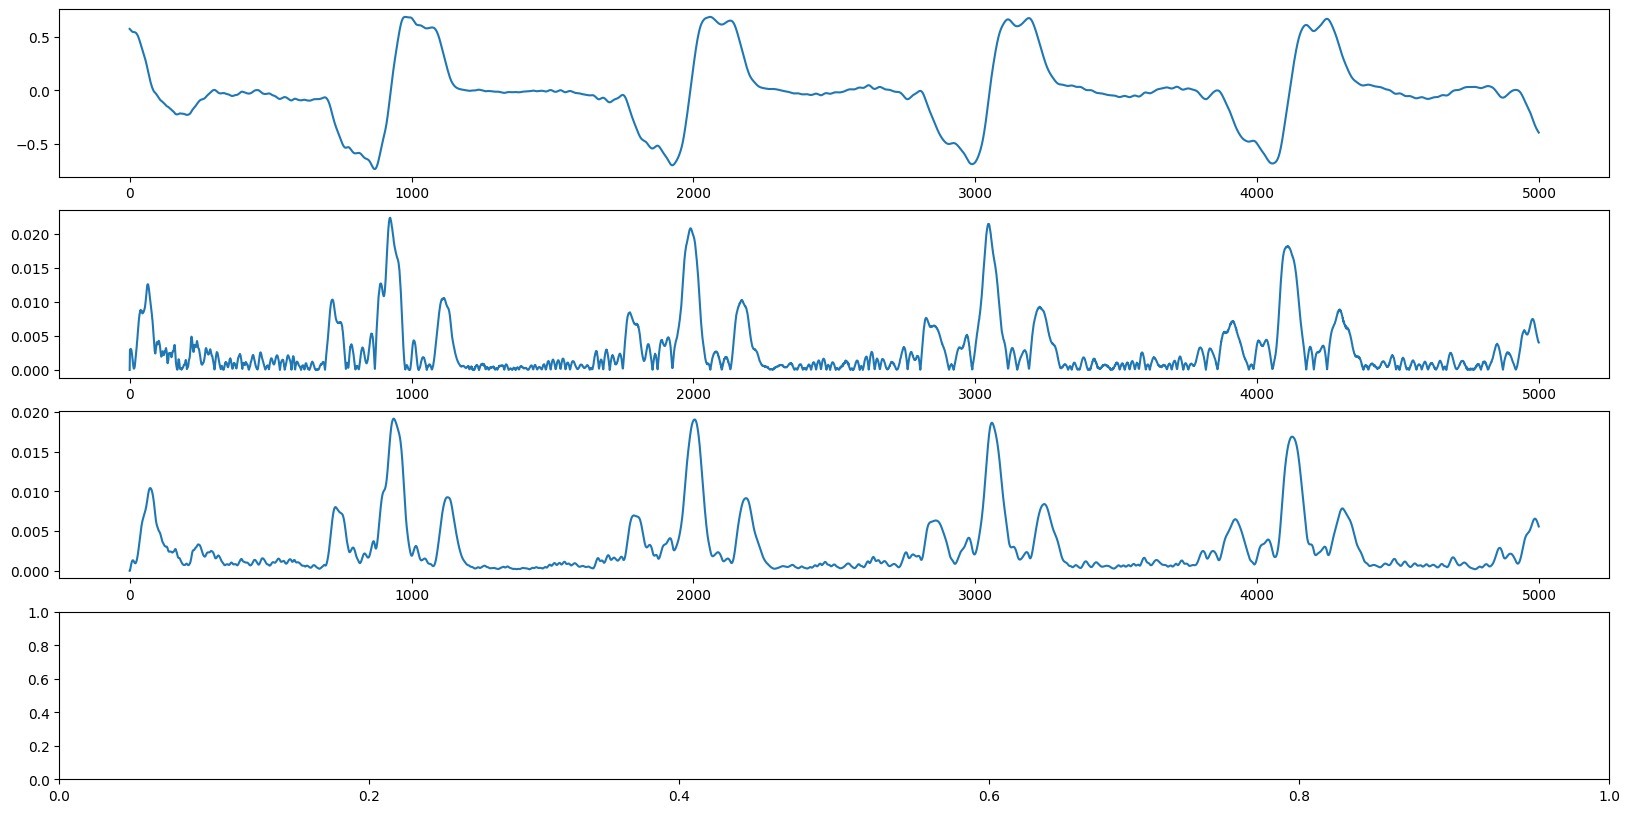

In [152]:
wav_values = []
wav_slope = []
wav_envelope = []
wav_envelope_non_linear = []
maxes = []

wav_start = 0
wav_len = 160000

slope_padding = 30

threshold=0.010

last_max = 0
current_max = 0


# Loads the wavefile into the frames `spf`
#spf = wave.open("16bit/Dee light.wav", "rb")
spf = wave.open("16bit/Recording.wav", "rb")

# Converts the frames into a byte array then into a numpy array and normalizes it
no_of_frames = spf.getnframes()
print(f"Number of frames: {no_of_frames}")
signal = spf.readframes(no_of_frames)
osc_bytes = signal #[wav_start:wav_start+wav_len*2]
#osc_bytes = signal[0:no_of_frames*2]

osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)

# There are needed to calculate the minimum number of steps to wait before the next peak
sample_rate = spf.getframerate()
max_freq = 200
min_freq = 40

min_peak_count = sample_rate / max_freq


envelope = 0
counter = 0
start_point = 50000
end_point = 5000
ranger = no_of_frames #10000000# len(osc_np_norm)
for i in range(0, end_point):

    # Append the current value of the signal to the wav_values array
    wav_values.append(osc_np_norm[i+start_point])

    # Calculate the slope of the signal from the difference between the current value to the previous value
    if i > 0:
        wav_slope.append(abs(osc_np_norm[i+start_point] - osc_np_norm[i+start_point-1]))
        # if counter > min_peak_count:
        #     if (wav_slope[i] > current_max) and (wav_slope[i] > 0.01):
        #         current_max = wav_slope[i]
        #         maxes.append(current_max)
        #         counter = 0
        #     else:
        #         maxes.append(0)
        # counter += 1
    else:
        wav_slope.append(0)

    # Add the envelope value calculated in the last loop to the wav_envelope array     
    wav_envelope.append(envelope)

    # Smooth the envelope by using the `slew` function
    envelope = slew(envelope, wav_slope[i],attack_coeff=attack_coeff, release_coeff=release_coeff)
    
    #Transform the envelope using the `non_linear_transform` function to try exagerate the peaks
    wav_envelope_non_linear.append(non_linear_transform(envelope,threshold=threshold))
    #print(f"{i}: {wav_values[i]} - {wav_slope[i]} - {wav_envelope[i]}")# - {wav_envelope_non_linear[i]}")

fig, axs = plt.subplots(4,1,figsize=(20,10))
axs[0].plot(wav_values)
axs[1].plot(wav_slope)
axs[2].plot(wav_envelope)
#axs[3].plot(maxes)
#axs[3].plot(wav_envelope_non_linear)    

In [135]:
wav_envelope[2000:2010]
wav_slope[2000:2010]

[0.0030517578125,
 0.0,
 0.00299072265625,
 0.0,
 0.003021240234375,
 0.0,
 0.003021240234375,
 0.0,
 0.003082275390625,
 0.0]

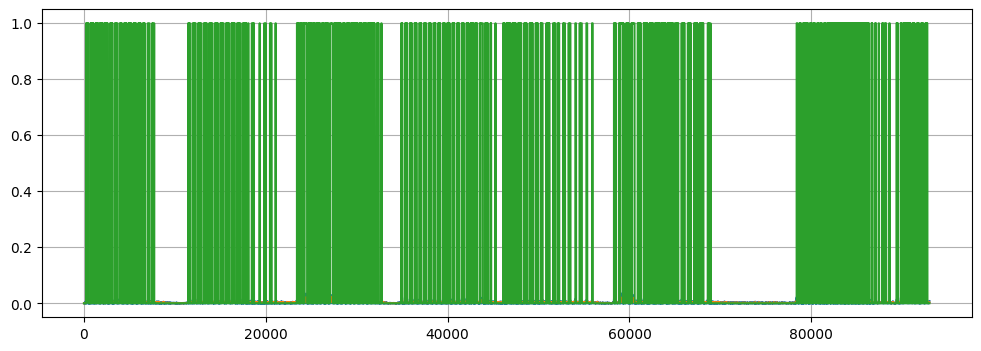

In [99]:
plt.figure(figsize=(12, 4))
#plt.plot(wav_values)
plt.plot(wav_slope)
plt.plot(wav_envelope)
plt.plot(wav_envelope_non_linear)
plt.grid()
plt.show()


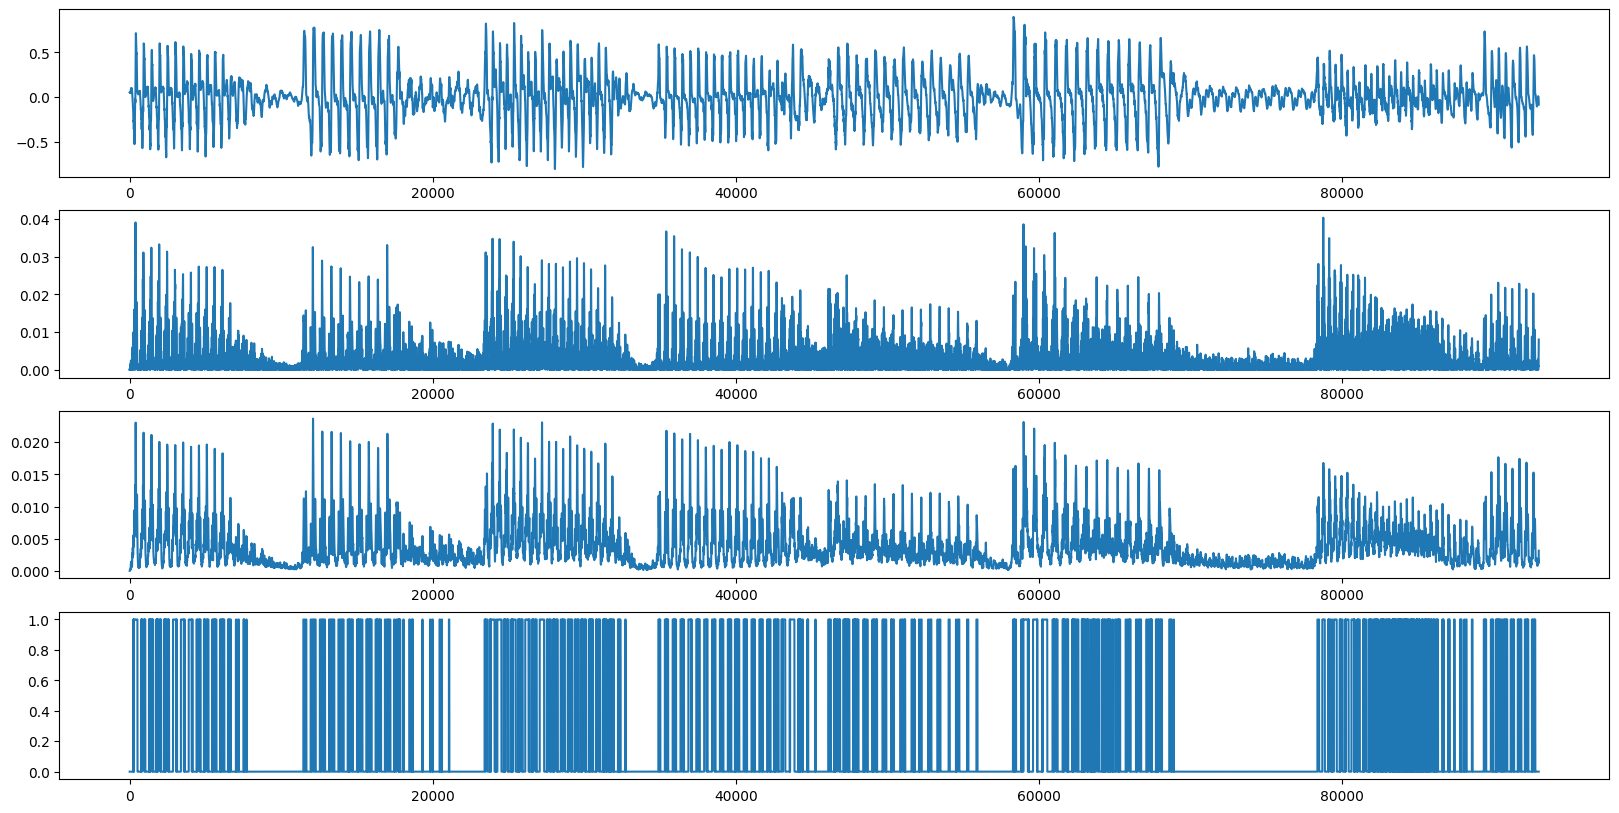

In [100]:
#plt.figure(figsize=(12, 4))
fig, axs = plt.subplots(4,1,figsize=(20,10))

axs[0].plot(wav_values)
axs[1].plot(wav_slope)
axs[2].plot(wav_envelope)
axs[3].plot(wav_envelope_non_linear)



In [68]:
min(wav_values)

-0.675811767578125

In [19]:
Audio(data=osc_np,rate=spf.getframerate())

Transient detection is a complex topic, but a simple and common approach is to use an envelope follower on the absolute value of the slope data, then find points where the envelope exceeds a certain threshold. Here's a basic implementation in Python using numpy:



In [ ]:
import numpy as np

def calculate_slopes(audio_data):
    # Ensure the input is a numpy array
    audio_data = np.array(audio_data)
    
    # Calculate the differences between each element and the previous one
    slopes = np.diff(audio_data)
    
    return slopes

def detect_transients(audio_data, threshold=0.5, attack_coeff=0.9, release_coeff=0.9):
    slopes = calculate_slopes(audio_data)
    envelope = 0
    transients = []
    
    for i, slope in enumerate(slopes):
        # Calculate the envelope
        if abs(slope) > envelope:
            envelope = attack_coeff * (envelope - abs(slope)) + abs(slope)
        else:
            envelope = release_coeff * (envelope - abs(slope)) + abs(slope)
        
        # If the envelope exceeds the threshold, we have a transient
        if envelope > threshold:
            transients.append(i)
    
    return transients



This code first calculates the slopes of the audio data, then iterates over the slopes. For each slope, it calculates an envelope value, which is a sort of smoothed, lagging version of the absolute slope. If the envelope exceeds a given threshold, it considers that point a transient and adds it to the list of transients.

The `attack_coeff` and `release_coeff` parameters control how quickly the envelope responds to changes in the slope. Values close to 1 make the envelope respond slowly (more smoothing), while values close to 0 make it respond quickly (less smoothing).

This is a very basic form of transient detection and may not work well for all types of audio data. More advanced methods involve more complex signal processing techniques.

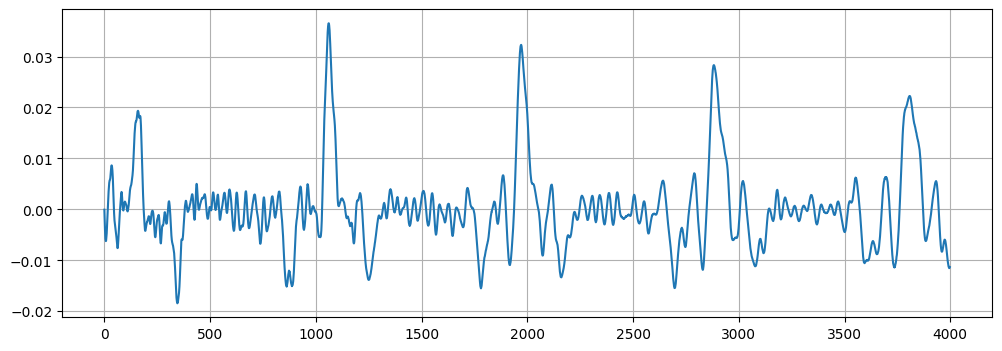

In [47]:
plt.figure(figsize=(12, 4))
spf = wave.open("16bit/Dee light [2024-03-19 212235].wav.wav", "rb")
signal = spf.readframes(spf.getnframes())
osc_bytes = signal[4000:12000]
osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)
plt.plot(np.diff(osc_np_norm,n=1))
plt.grid()
plt.show()


#osc_np[1000]

In [55]:
def draw_wavs(file_name):
    spf = wave.open(file_name, "rb")

    signal = spf.readframes(-1)

    fig, plots = plt.subplots(8, 2,figsize=(20,40))

    counter = 0
    for i,row_plot in enumerate(plots):
        for j,plot in enumerate(row_plot):
            osc_bytes = signal[counter*12000:(counter+1)*12000]
            osc_np = np.frombuffer(osc_bytes,dtype="int32") 
            osc_np_norm = osc_np/(2 ** 16/2)
            plot.plot(osc_np_norm)
            plot.plot(np.diff(osc_np_norm,n=1)*20)
            # plot.plot(osc_np)
            plot.grid()
            #plot.axis('off')
            counter += 1

    fig.savefig('images_60.png')        

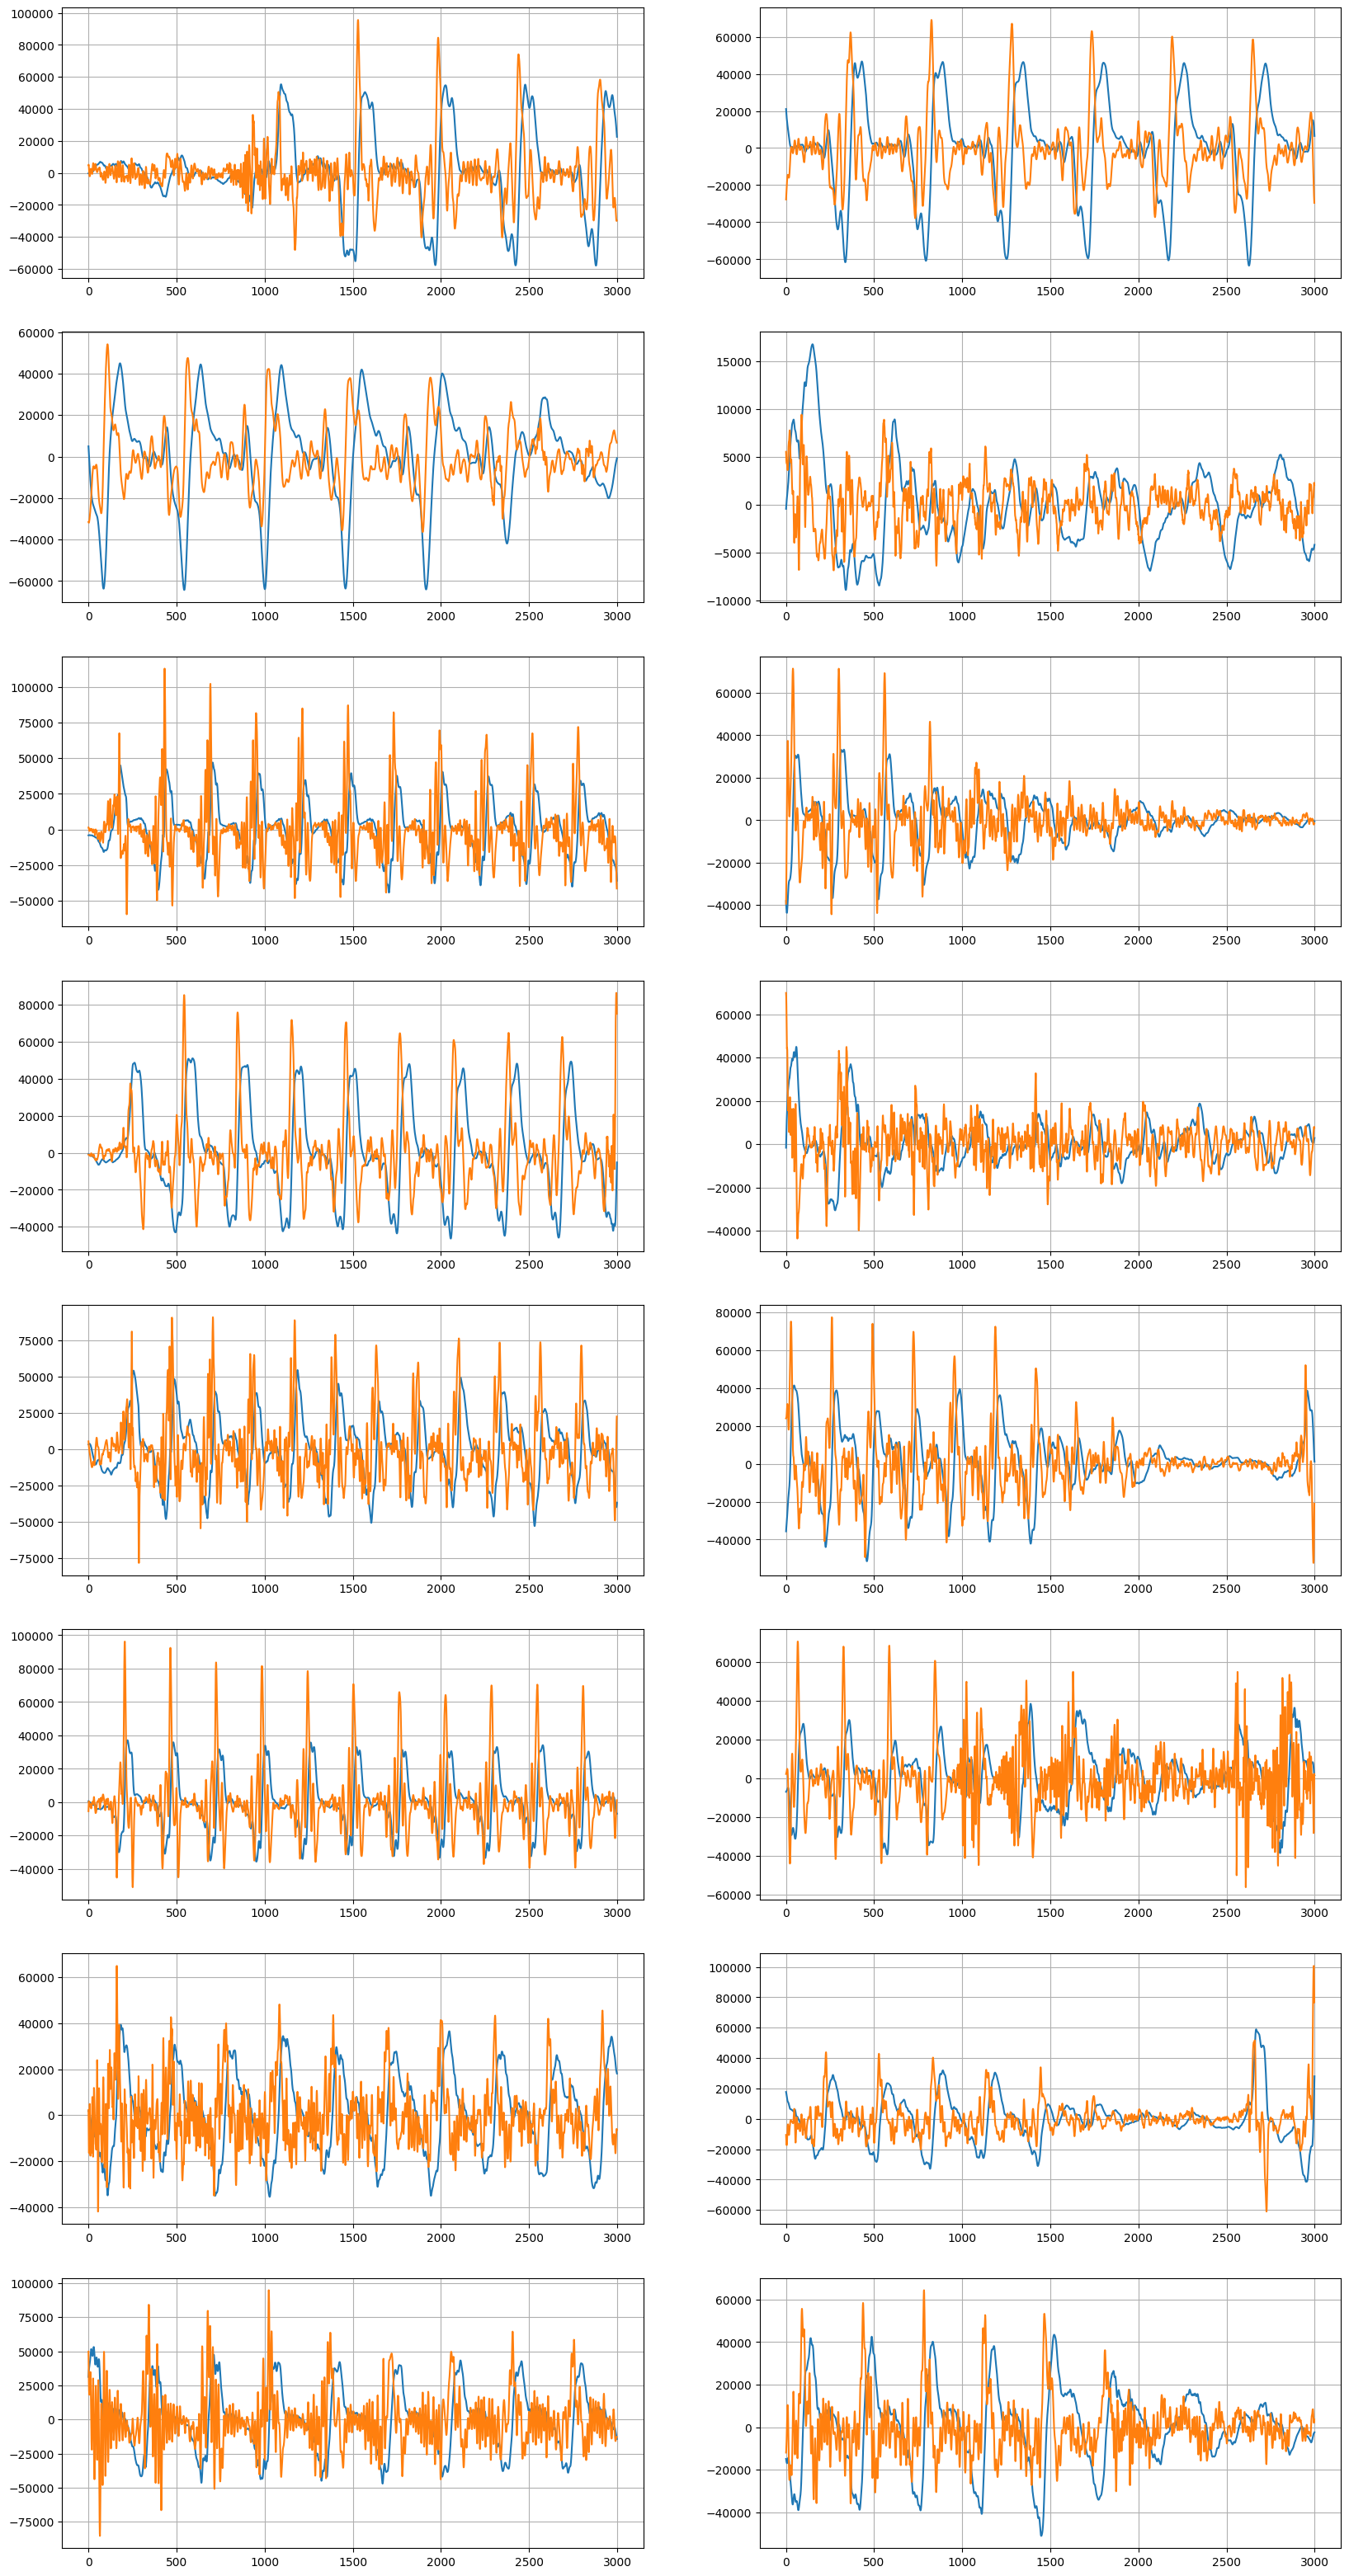

In [56]:
draw_wavs("16bit/Dee light [2024-03-19 212235].wav.wav")
# waves to add
#9,30,34,48

In [73]:
import audioop

wav_in = wave.open("AKWF_60_ordered.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())

wav_data = b''
for i in keep:
    wav_data += all_frames[(i-1)*1200:(i)*1200]

#130.8128
#146.8324
sample_rate_change = 147.1/131
wav_data = audioop.ratecv(wav_data, 2, 1, 44100, 49621, None)
wave_out = wave.open("AKWF_SMALL.wav", mode='wb')
wave_out.setnchannels(1) # mono
wave_out.setsampwidth(2)
wave_out.setframerate(44100)
#wave_out.setnframes(len(keep)*1200)
wave_out.writeframesraw(wav_data)
wave_out.close()

In [87]:
wav_in_sin = wave.open("1_sin.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())
len(all_frames)

734

In [47]:

wav_in = wave.open("AKWF_SMALL.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())

sample_rate_change = 147.1/131
wav_data = audioop.ratecv(all_frames, 2, 1, 44100, 22050, None)
wave_out = wave.open("AKWF_SMALL_12.wav", mode='wb')
wave_out.setnchannels(1) # mono
wave_out.setsampwidth(2)
wave_out.setframerate(44100)
#wave_out.setnframes(len(keep)*1200)
wave_out.writeframesraw(wav_data[0])
wave_out.close()